# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using DeepTime package to cluster them.

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.clustering import BoxDiscretization

import mdtraj as md
import re, math, os, shutil

import warnings; warnings.simplefilter('ignore')

### Import the data 

In [3]:
# import omega data
omegas = np.load('omega_data/omegas_state0.npy')
print(omegas)
print(f"omegas.shape: {omegas.shape}")
print(f"omegas.dtype: {omegas.dtype}")

[[-131.94534   -164.36684   -168.73222   ...  155.54361    169.69421
  -178.63116  ]
 [-167.8904    -177.17209    162.46188   ...  149.18318   -159.73303
  -144.3094   ]
 [-129.7263    -171.66838    173.76761   ...  152.26566    169.96507
  -172.13924  ]
 ...
 [  -5.6512365  167.33704    -19.32506   ...   17.76739    172.3323
  -163.80467  ]
 [  15.203393   179.08969    -13.279527  ...    1.6395142  167.58357
   169.31448  ]
 [  51.72642   -175.62971      7.98296   ...  -33.5042     167.44174
     7.6826086]]
omegas.shape: (30001, 9)
omegas.dtype: float32


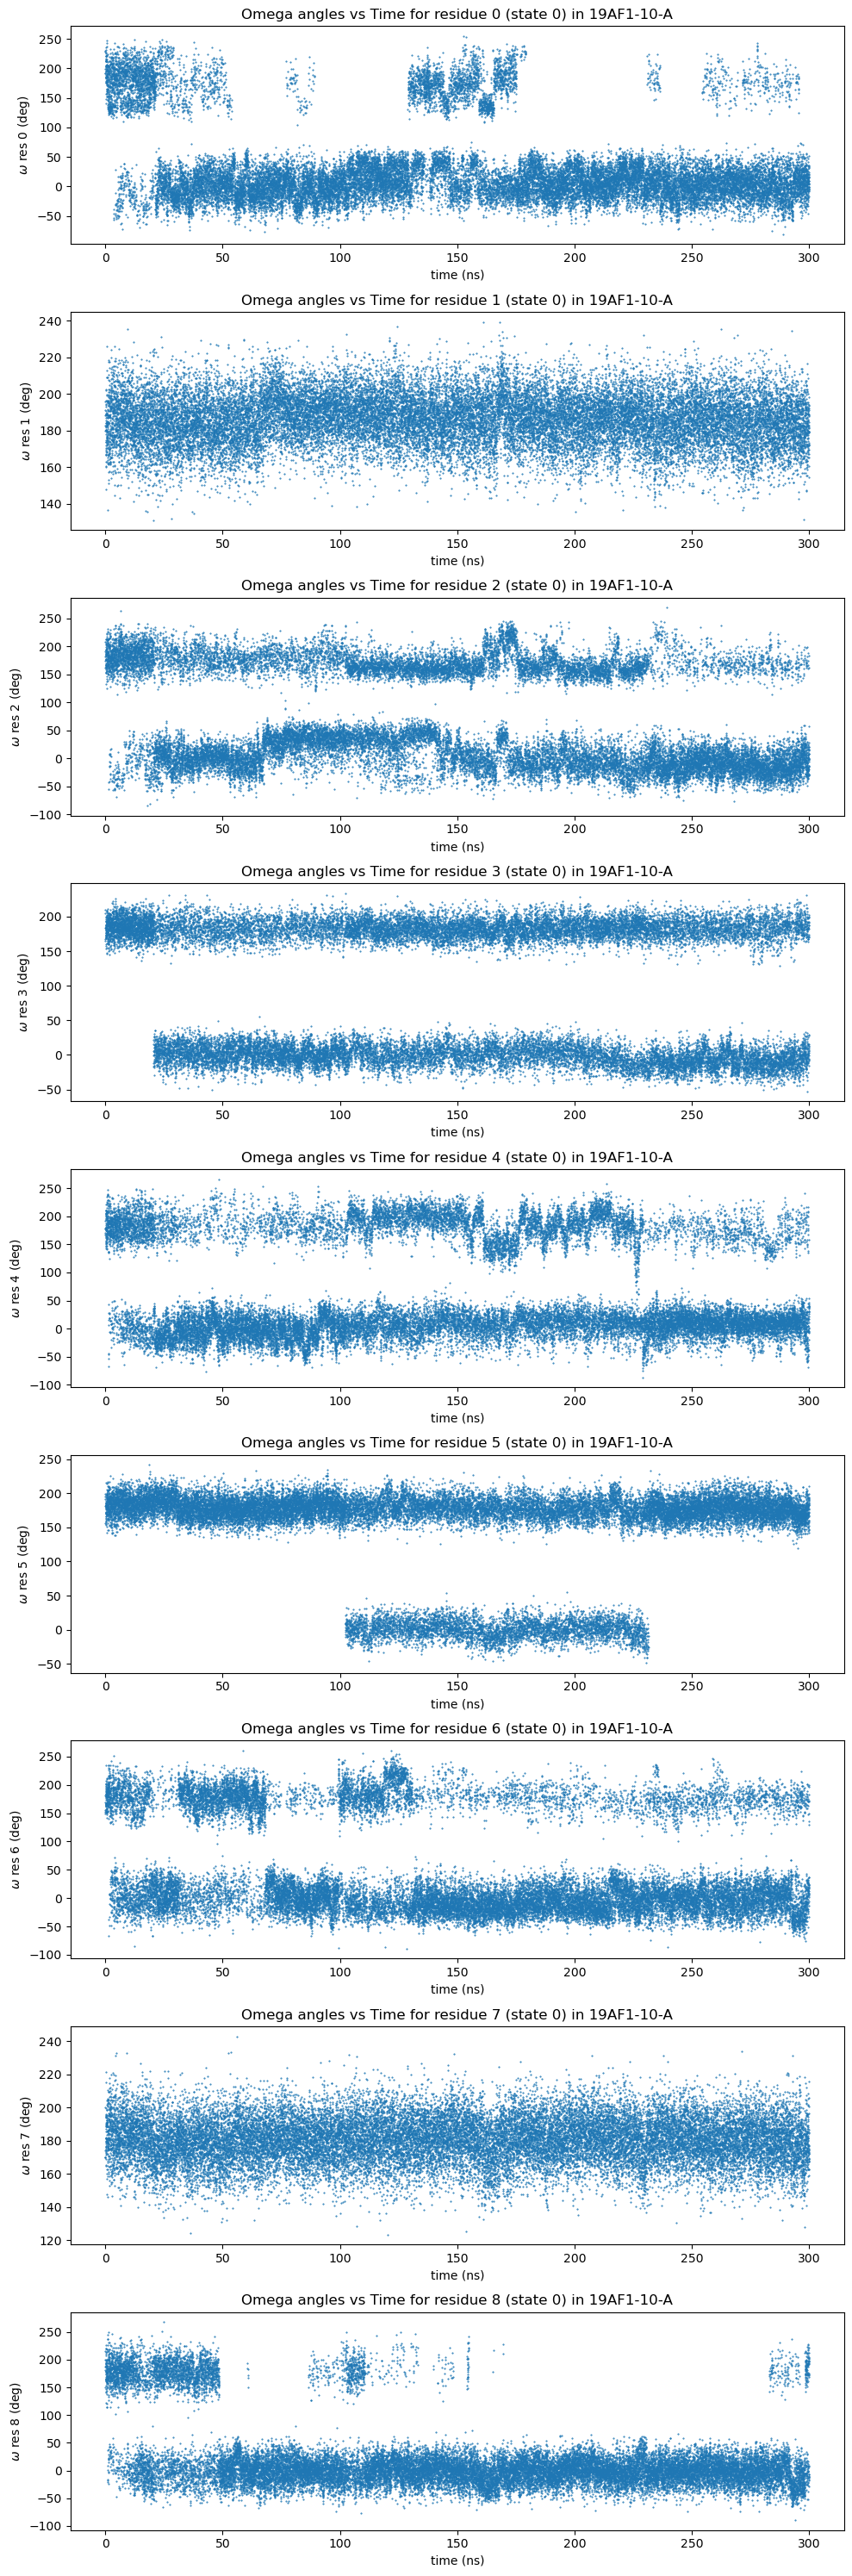

In [4]:
# Plotting the omegas 
omegas = (omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

start = 0
nsnaps = 30001
t = np.arange(start, nsnaps) * 0.01 # Tims axis in ns 
residues_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8]
num_residues = len(residues_to_plot)

plt.figure(figsize=(10, 30))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omegas[start:nsnaps, residue], '.', ms=1)
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ res {residue} (deg)')
    plt.title(f'Omega angles vs Time for residue {residue} (state 0) in 19AF1-10-A')
plt.tight_layout()
plt.show()

### Clustering Method

In [5]:
regularspace_estimator = RegularSpace(
    dmin=170,        # minimum distance between cluster centers, 180 degree
    max_centers=128,   # maximum number of cluster centers
    n_jobs=8
)

kmean_estimator = KMeans(
    n_clusters=128,              # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=100000000,        # don't actually perform the optimization, just place centers
    fixed_seed=42,             # Treat this as hyperparameter 
    n_jobs=8,
    progress=tqdm
)

In [6]:
# Fit the omegas data into model 
clustering = regularspace_estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

print(clustering.cluster_centers)

[[ 2.28054657e+02  1.95633179e+02  1.91267761e+02  1.64694733e+02
   1.70566162e+02  1.81913208e+02  1.55543610e+02  1.69694214e+02
   1.81368835e+02]
 [ 1.83865601e+02  1.86786194e+02  1.87750946e+02  1.65325577e+02
   1.90618195e+02  1.83952606e+02  1.95775452e+02  1.76422546e+02
  -1.77506790e+01]
 [ 1.91110107e+02  1.95929382e+02  1.59647720e+02  1.81529358e+02
  -4.45535698e+01  2.10982117e+02  2.06127197e+02  1.78315491e+02
   1.68148560e+02]
 [ 1.91350403e+02  1.96352661e+02 -4.32598495e+01  1.68513855e+02
   1.82603699e+02  1.84499939e+02  1.87480408e+02  2.02649841e+02
   1.82032043e+02]
 [ 1.70651459e+02  2.01058228e+02  1.50151016e+02  1.94855469e+02
  -4.61172523e+01  1.82102173e+02 -3.71593704e+01  1.68790710e+02
   1.36848358e+02]
 [ 1.68104919e+02  1.96724854e+02  1.93060242e+02  1.93112030e+02
   1.96096741e+02  1.89997375e+02  4.43566132e+00  1.94649963e+02
   2.25689575e+02]
 [ 1.76934204e+02  2.09630615e+02 -3.22636223e+01  1.78674133e+02
   1.37519592e+02  1.6150202

### The population of each cluster:

In [50]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())
cluster = []

for label, frequency in sorted_counts.items():    
    precentage = (frequency / total_counts) * 100 
    cluster.append(precentage)
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

outfile = 'sampling/clusters_probability.dat'
np.savetxt(outfile, cluster)

Assignment 0: 620, 2.067%
Assignment 1: 290, 0.9666%
Assignment 2: 6, 0.02%
Assignment 3: 27, 0.09%
Assignment 4: 101, 0.3367%
Assignment 5: 191, 0.6366%
Assignment 6: 47, 0.1567%
Assignment 7: 272, 0.9066%
Assignment 8: 101, 0.3367%
Assignment 9: 38, 0.1267%
Assignment 10: 213, 0.71%
Assignment 11: 391, 1.303%
Assignment 12: 340, 1.133%
Assignment 13: 215, 0.7166%
Assignment 14: 1554, 5.18%
Assignment 15: 38, 0.1267%
Assignment 16: 702, 2.34%
Assignment 17: 217, 0.7233%
Assignment 18: 568, 1.893%
Assignment 19: 120, 0.4%
Assignment 20: 1069, 3.563%
Assignment 21: 414, 1.38%
Assignment 22: 2586, 8.62%
Assignment 23: 896, 2.987%
Assignment 24: 2047, 6.823%
Assignment 25: 6205, 20.68%
Assignment 26: 363, 1.21%
Assignment 27: 38, 0.1267%
Assignment 28: 103, 0.3433%
Assignment 29: 4817, 16.06%
Assignment 30: 86, 0.2867%
Assignment 31: 1571, 5.236%
Assignment 32: 113, 0.3767%
Assignment 33: 38, 0.1267%
Assignment 34: 460, 1.533%
Assignment 35: 3, 0.01%
Assignment 36: 90, 0.3%
Assignment 37:

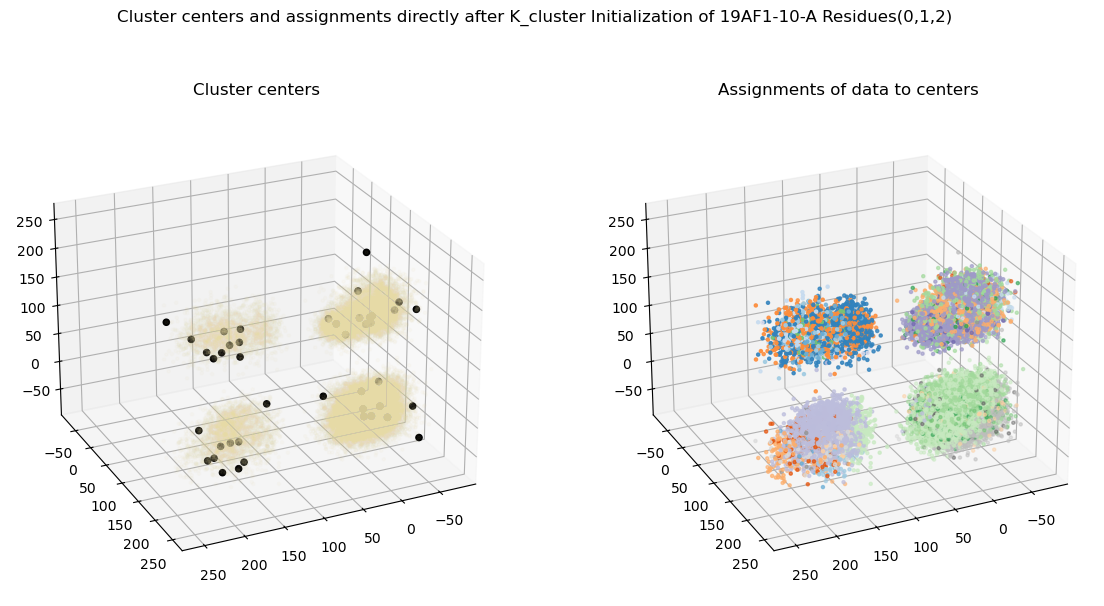

In [9]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(0,1,2)')
fig.savefig('omega_data/cluster_centers_and_assignments_residues(0,1,2).png', dpi=300, bbox_inches='tight')
plt.show()

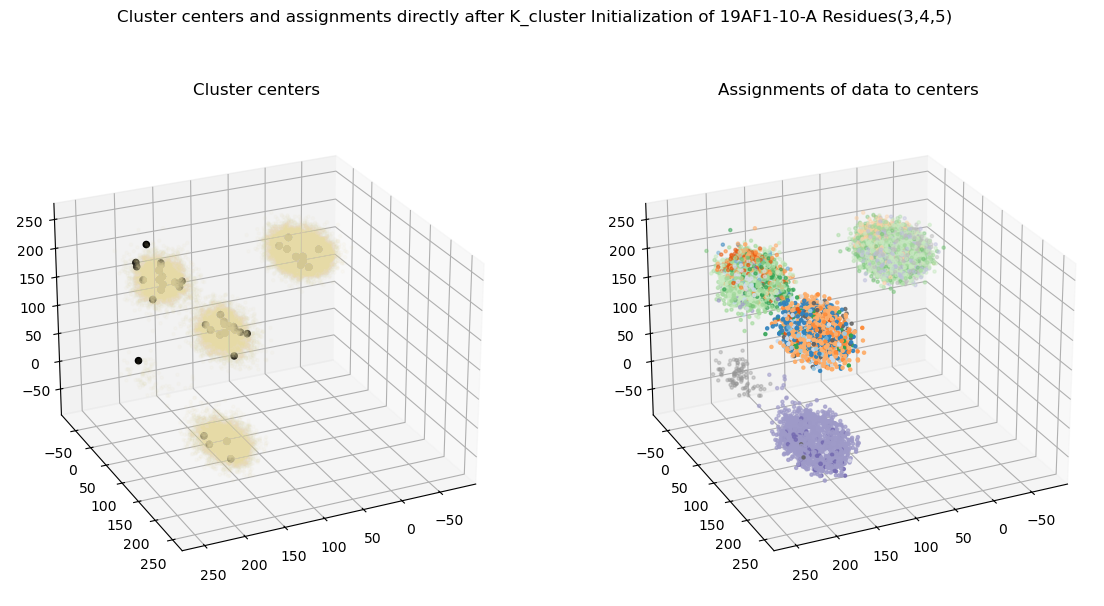

In [10]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 3], clustering.cluster_centers[:, 4], clustering.cluster_centers[:, 5], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(3,4,5)')
fig.savefig('omega_data/cluster_centers_and_assignments_residues(3,4,5).png', dpi=300, bbox_inches='tight')
plt.show()

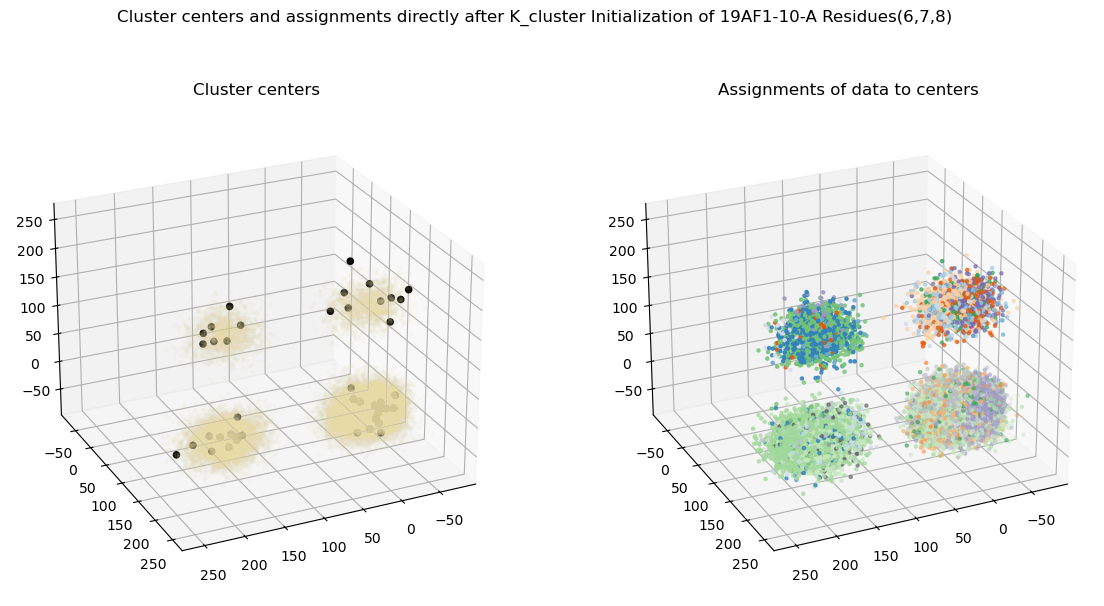

In [11]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 6], omegas[:, 7], omegas[:, 8], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 6], clustering.cluster_centers[:, 7], clustering.cluster_centers[:, 8], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 6], omegas[:, 7], omegas[:, 8], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(6,7,8)')
fig.savefig('omega_data/cluster_centers_and_assignments_residues(6,7,8).png', dpi=300, bbox_inches='tight')
plt.show()

### Calculate the Inertias:

$$
\sum_{i=1}^{k} \sum_{x_j \in S_i} \|\mathbf{x}_j - \mu_i\|^2
$$


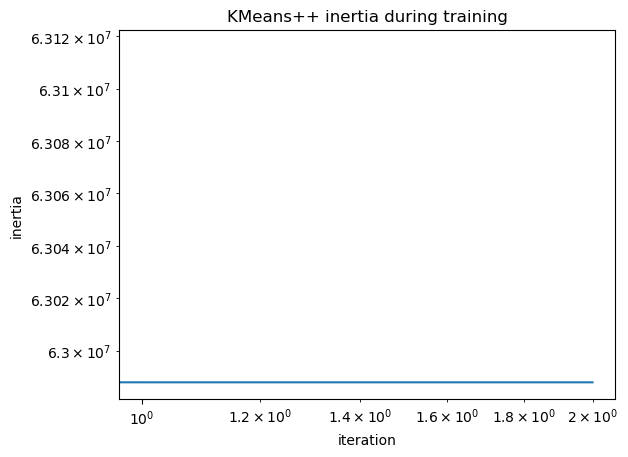

In [29]:
plt.loglog(clustering.inertias)
plt.xlabel("iteration")
plt.ylabel("inertia")
plt.title("KMeans++ inertia during training");

### Plot the Solution NMR Crystal Structure 

In [12]:
# Define dihedral indices
gmx_dihedral_indices = [
    [2, 4, 27, 28],
    [28, 30, 60, 61],
    [61, 63, 86, 87],
    [87, 89, 127, 128],
    [128, 130, 152, 153],
    [153, 155, 186, 187],
    [187, 189, 206, 207],
    [207, 209, 231, 232],
    [232, 234, 252, 253],
]

# Convert indices to zero-based for numpy
nmr_dihedral_indices = np.array(gmx_dihedral_indices) - 1
#print(nmr_dihedral_indices.shape)

# Load NMR structure
pdb = '../../../nmr_structure/ja9b10497_si_005.pdb'
traj = md.load(pdb)
nmr_omegas = []

# Compute dihedrals for each segment
for i in range(10):
    indices_offset = nmr_dihedral_indices + 288 * i
    nmr_omegas_single = md.compute_dihedrals(traj, indices_offset) * (180.0 / math.pi)
    nmr_omegas.append(nmr_omegas_single)
    
nmr_omegas = np.array(nmr_omegas).reshape(10,9)
print(nmr_omegas, nmr_omegas.shape)

# Save omegas
omega_path = 'omega_data/'
outfile = os.path.join(omega_path, f"NMR_omegas.npy")
np.save(outfile, nmr_omegas)
print(f"Saved NMR omegas to {outfile}") 

[[-2.32945576e+01  1.74726089e+02  8.51800632e+00 -1.63803009e+02
   1.47048254e+01 -1.79822067e+02  5.85368443e+00 -1.65111755e+02
  -1.36412382e+01]
 [ 1.56054049e+01 -1.78664780e+02 -2.47104797e+01 -1.74066071e+02
  -9.26567268e+00  1.72371643e+02  2.23368645e+01  1.78056641e+02
   2.92227244e+00]
 [-3.43375564e-01  1.79917603e+02 -8.99483490e+00  1.79011780e+02
   4.05032063e+00  1.70098785e+02 -1.04584236e+01  1.76911453e+02
  -2.08330840e-01]
 [-9.89397645e-01  1.69737518e+02  1.26592219e+00  1.78353165e+02
   3.59419537e+00 -1.77253174e+02 -3.10515833e+00  1.74316116e+02
   7.14647865e+00]
 [-5.98919106e+00 -1.78984406e+02 -4.06650782e+00  1.69978790e+02
   1.03207219e+00 -1.65114807e+02  1.05245485e+01  1.70020874e+02
  -5.08468866e+00]
 [ 7.33606386e+00 -1.75269989e+02  5.75529480e+00  1.70737183e+02
  -1.13240585e+01 -1.71270157e+02 -8.73217487e+00 -1.58323608e+02
   2.15789199e+00]
 [ 8.60093021e+00 -1.62091431e+02 -6.61632252e+00  1.69344284e+02
   1.14710855e+01  1.6789502

In [50]:
#### CHECK CODE ####

# Define dihedral indices
gmx_dihedral_indices = [
    [2, 4, 27, 28],
    [28, 30, 60, 61],
    [61, 63, 86, 87],
    [87, 89, 127, 128],
    [128, 130, 152, 153],
    [153, 155, 186, 187],
    [187, 189, 206, 207],
    [207, 209, 231, 232],
    [232, 234, 252, 253],
]

# Convert indices to zero-based for numpy
nmr_dihedral_indices = np.array(gmx_dihedral_indices) - 1

# Load NMR structure
pdb = '../../../nmr_structure/ja9b10497_si_005.pdb'
traj = md.load(pdb)
topology = traj.topology

# Function to get atom names from indices
def get_atom_names(indices):
    atom_names = []
    for index in indices:
        atom_names.append(topology.atom(index).name)
    return atom_names

# Compute dihedrals for each segment and print atom names
for i in range(10):
    indices_offset = nmr_dihedral_indices + 288 * i
    print(f"Indices offset for segment {i+1}:")
    print(indices_offset)
    for indices in indices_offset:
        atom_names = get_atom_names(indices)
        print(f"Atom names for indices {indices}: {atom_names}")
    
    nmr_omegas_single = md.compute_dihedrals(traj, indices_offset) * (180.0 / math.pi)
    print(f"Dihedrals for segment {i+1}:")
    print(nmr_omegas_single)
    print()

Indices offset for segment 1:
[[  1   3  26  27]
 [ 27  29  59  60]
 [ 60  62  85  86]
 [ 86  88 126 127]
 [127 129 151 152]
 [152 154 185 186]
 [186 188 205 206]
 [206 208 230 231]
 [231 233 251 252]]
Atom names for indices [ 1  3 26 27]: ['CA', 'C', 'N', 'CA']
Atom names for indices [27 29 59 60]: ['CA', 'C', 'N', 'CA']
Atom names for indices [60 62 85 86]: ['CA', 'C', 'N', 'CA']
Atom names for indices [ 86  88 126 127]: ['CA', 'C', 'N', 'CA']
Atom names for indices [127 129 151 152]: ['CA', 'C', 'N', 'CA']
Atom names for indices [152 154 185 186]: ['CA', 'C', 'N', 'CA']
Atom names for indices [186 188 205 206]: ['CA', 'C', 'N', 'CA']
Atom names for indices [206 208 230 231]: ['CA', 'C', 'N', 'CA']
Atom names for indices [231 233 251 252]: ['CA', 'C', 'N', 'CA']
Dihedrals for segment 1:
[[ -23.294558   174.72609      8.518006  -163.80301     14.704825
  -179.82207      5.8536844 -165.11176    -13.641238 ]]

Indices offset for segment 2:
[[289 291 314 315]
 [315 317 347 348]
 [348 350

In [14]:
nmr_omegas = np.load('omega_data/NMR_omegas.npy')
print(f"nmr_omegas.shape: {nmr_omegas.shape}")
print(f"nmr_omegas.dtype: {nmr_omegas.dtype}")

nmr_omegas = (nmr_omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)
print(nmr_omegas)

nmr_omegas.shape: (10, 9)
nmr_omegas.dtype: float32
[[-2.32945557e+01  1.74726074e+02  8.51800537e+00  1.96196991e+02
   1.47048264e+01  1.80177917e+02  5.85368347e+00  1.94888245e+02
  -1.36412354e+01]
 [ 1.56054077e+01  1.81335205e+02 -2.47104797e+01  1.85933929e+02
  -9.26567078e+00  1.72371643e+02  2.23368683e+01  1.78056641e+02
   2.92227173e+00]
 [-3.43376160e-01  1.79917603e+02 -8.99483490e+00  1.79011780e+02
   4.05032349e+00  1.70098785e+02 -1.04584198e+01  1.76911438e+02
  -2.08328247e-01]
 [-9.89395142e-01  1.69737518e+02  1.26592255e+00  1.78353149e+02
   3.59419250e+00  1.82746826e+02 -3.10515594e+00  1.74316101e+02
   7.14647675e+00]
 [-5.98918915e+00  1.81015594e+02 -4.06650543e+00  1.69978790e+02
   1.03207397e+00  1.94885193e+02  1.05245514e+01  1.70020874e+02
  -5.08468628e+00]
 [ 7.33606720e+00  1.84730011e+02  5.75529480e+00  1.70737183e+02
  -1.13240585e+01  1.88729858e+02 -8.73217773e+00  2.01676392e+02
   2.15789032e+00]
 [ 8.60092926e+00  1.97908569e+02 -6.61632

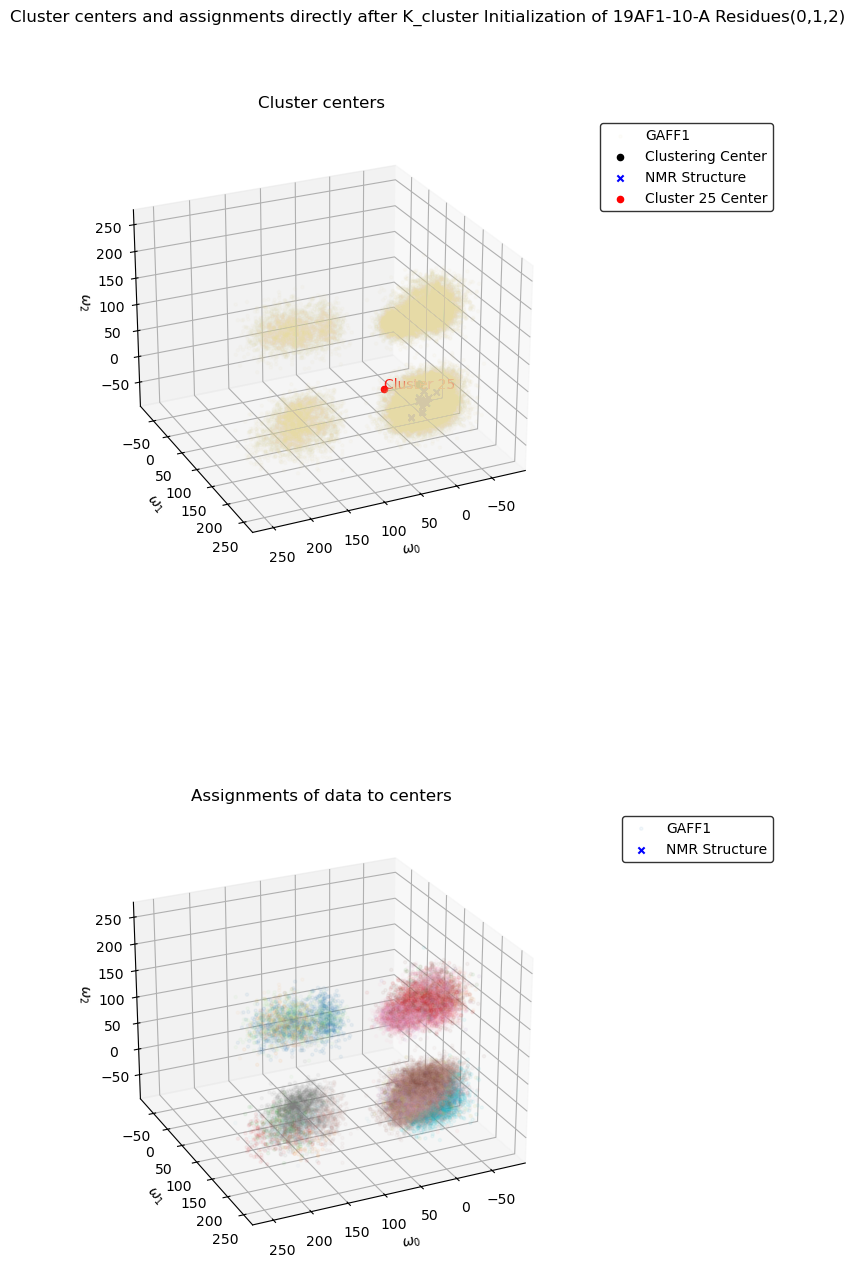

In [51]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05, label='GAFF1')
ax1.scatter(clustering.cluster_centers[20, 0], clustering.cluster_centers[20, 1], clustering.cluster_centers[20, 2], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(nmr_omegas[:, 0], nmr_omegas[:, 1], nmr_omegas[:, 2], marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Plot the center of cluster 
cluster_index = 25
x, y, z = clustering.cluster_centers[cluster_index][:3]  # Extract the first three coordinates
ax1.scatter(x, y, z, c='r', marker='o', alpha=1, label=f'Cluster {cluster_index} Center')
ax1.text(x, y, z, f'Cluster {cluster_index}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.05 , cmap='tab20', label='GAFF1')
ax2.scatter(nmr_omegas[:, 0], nmr_omegas[:, 1], nmr_omegas[:, 2], marker = 'x', alpha=1, c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_0$')
ax1.set_ylabel(r'$\omega_1$')
ax1.set_zlabel(r'$\omega_2$')

ax2.set_xlabel(r'$\omega_0$')
ax2.set_ylabel(r'$\omega_1$')
ax2.set_zlabel(r'$\omega_2$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(0,1,2)')
fig.savefig('omega_data/cluster_centers_and_assignments_residue(0,1,2).png', dpi=300, bbox_inches='tight')
plt.show()

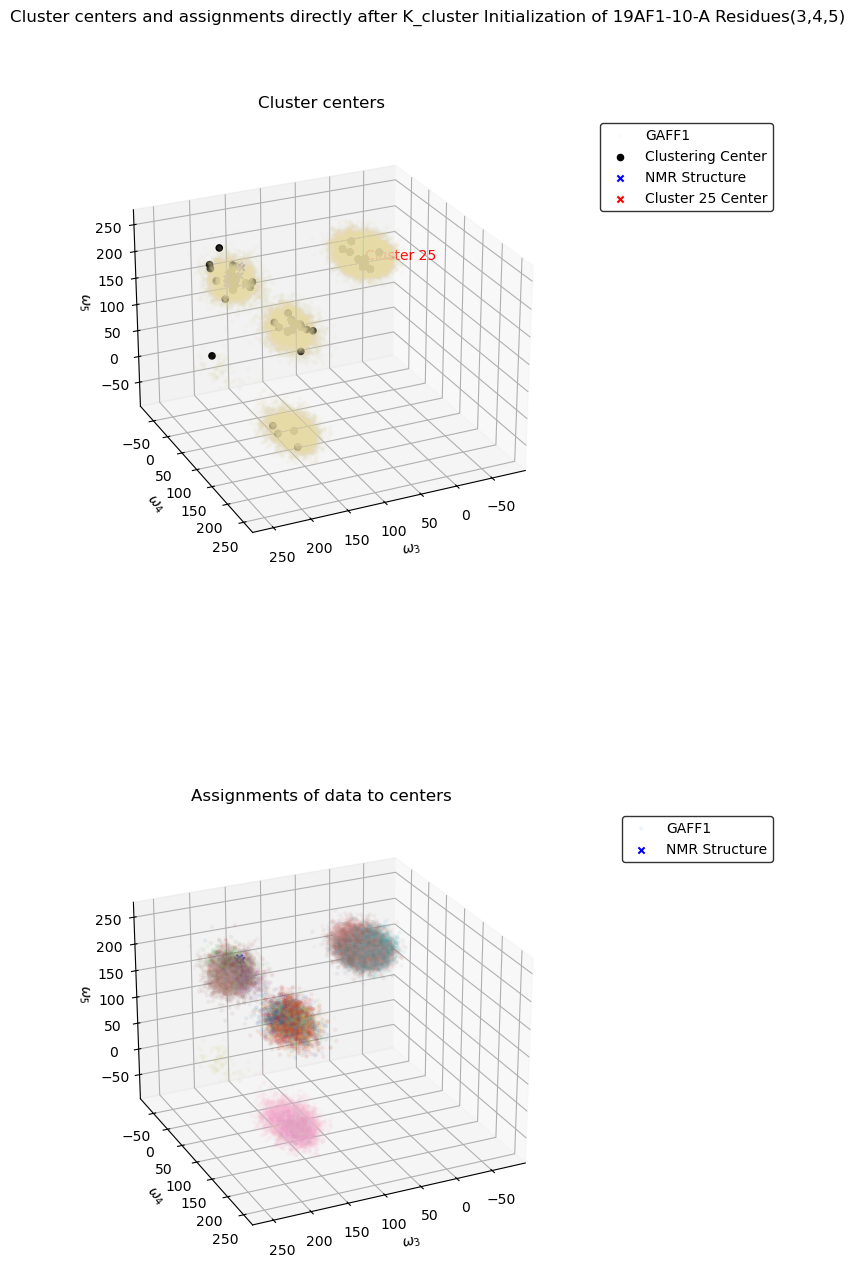

In [52]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c='#E6DAA6', marker='.', alpha=0.05, label='GAFF1')
ax1.scatter(clustering.cluster_centers[:, 3], clustering.cluster_centers[:, 4], clustering.cluster_centers[:, 5], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(nmr_omegas[:, 3], nmr_omegas[:, 4], nmr_omegas[:, 5], marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Plot the center of cluster
cluster_index = 25
x, y, z = clustering.cluster_centers[cluster_index][3:6]  # Extract the first three coordinates
ax1.scatter(x, y, z, c='r', marker='x', alpha=1, label=f'Cluster {cluster_index} Center')
ax1.text(x, y, z, f'Cluster {cluster_index}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 3], omegas[:, 4], omegas[:, 5], c=assignments[:], marker='.', alpha=0.05 , cmap='tab20', label='GAFF1')
ax2.scatter(nmr_omegas[:, 3], nmr_omegas[:, 4], nmr_omegas[:, 5], marker = 'x', alpha=1, c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_3$')
ax1.set_ylabel(r'$\omega_4$')
ax1.set_zlabel(r'$\omega_5$')

ax2.set_xlabel(r'$\omega_3$')
ax2.set_ylabel(r'$\omega_4$')
ax2.set_zlabel(r'$\omega_5$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(3,4,5)')
fig.savefig('omega_data/cluster_centers_and_assignments_residue(3,4,5).png', dpi=300, bbox_inches='tight')
plt.show()

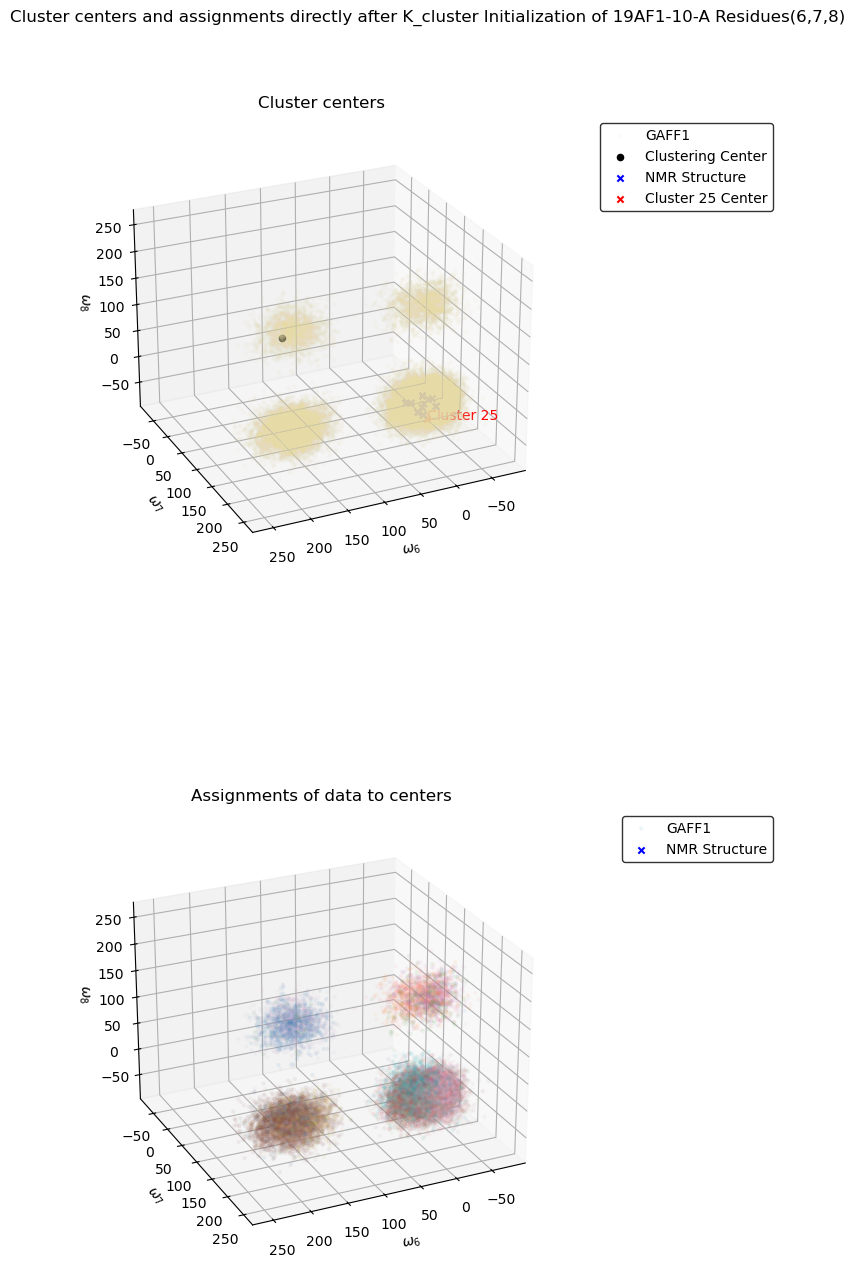

In [53]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 6], omegas[:, 7], omegas[:, 8], c='#E6DAA6', marker='.', alpha=0.05, label='GAFF1')
ax1.scatter(clustering.cluster_centers[20, 6], clustering.cluster_centers[20, 7], clustering.cluster_centers[20, 8], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(nmr_omegas[:, 6], nmr_omegas[:, 7], nmr_omegas[:, 8], marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Plot the center of cluster
cluster_index = 25
x, y, z = clustering.cluster_centers[cluster_index][6:9]  # Extract the first three coordinates
ax1.scatter(x, y, z, c='r', marker='x', alpha=1, label=f'Cluster {cluster_index} Center')
ax1.text(x, y, z, f'Cluster {cluster_index}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 6], omegas[:, 7], omegas[:, 8], c=assignments[:], marker='.', alpha=0.05 , cmap='tab20', label='GAFF1')
ax2.scatter(nmr_omegas[:, 6], nmr_omegas[:, 7], nmr_omegas[:, 8], marker = 'x', alpha=1, c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_6$')
ax1.set_ylabel(r'$\omega_7$')
ax1.set_zlabel(r'$\omega_8$')

ax2.set_xlabel(r'$\omega_6$')
ax2.set_ylabel(r'$\omega_7$')
ax2.set_zlabel(r'$\omega_8$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K_cluster Initialization of 19AF1-10-A Residues(6,7,8)')
fig.savefig('omega_data/cluster_centers_and_assignments_residue(6,7,8).png', dpi=300, bbox_inches='tight')
plt.show()

### Sampling from Clusters

In [44]:
# Define the directory path
directory = "sampling/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")

All contents in 'sampling/' have been cleared.


In [47]:
import numpy as np
import mdtraj as md

# Create Cluster Dictionary
clusters = {assignment: [] for assignment in np.unique(assignments)}
#print(cluster)

# Store the frame index in each cluster
for index, assignment in enumerate(assignments):
    clusters[assignment].append(index)

#print(cluster)
print(type(clusters))
print(clusters[1])

# Create Frame Dictionary for containing the sampling frame 
frames = {assignment: [] for assignment in np.unique(assignments)}
#print(frames)
print(len(frames))

# Define cluster size
size = 3

# Randomly sample 10 frames from each cluster
for i in range(len(frames)):
    if len(clusters[i]) >= size:
        indices = np.random.choice(clusters[i], size=size, replace=True)
        frames[i] = indices.tolist()
    else:
        print(f"Cluster {i} skipped. Only {len(clusters[i])} frames available.")


# Load trajectory
xtcfile = "state_0/HREMD.part0001_whole.xtc"
grofile = "state_0/HREMD.part0001_withoutsolvent.gro"
traj = md.load(xtcfile, top=grofile)

# Save sampled frames to new xtc files
for cluster in frames:
    sampling = traj[frames[cluster]]    
    sampling.save_xtc(f"sampling/sample_state_0_cluster{cluster}.xtc")
    sampling.save_pdb(f"sampling/sample_state_0_cluster{cluster}.pdb")

<class 'dict'>
[88, 89, 102, 103, 112, 113, 118, 119, 122, 123, 126, 127, 138, 139, 150, 151, 164, 165, 174, 175, 192, 193, 202, 203, 212, 213, 216, 217, 228, 229, 240, 241, 252, 253, 272, 273, 300, 301, 312, 313, 318, 319, 320, 321, 322, 323, 1474, 1475, 1478, 1479, 1498, 1499, 1510, 1511, 1522, 1523, 1526, 1527, 1528, 1529, 1542, 1543, 1550, 1551, 1570, 1571, 1582, 1583, 1594, 1595, 1596, 1597, 1608, 1609, 1620, 1621, 1624, 1625, 1636, 1637, 1640, 1641, 1650, 1651, 1652, 1653, 1664, 1665, 1684, 1685, 1686, 1687, 1688, 1689, 1718, 1719, 1734, 1735, 1746, 1747, 1752, 1753, 1762, 1763, 1774, 1775, 1784, 1785, 1790, 1791, 1804, 1805, 1806, 1807, 1810, 1811, 1812, 1813, 1816, 1817, 1838, 1839, 1850, 1851, 1862, 1863, 1874, 1875, 1890, 1891, 1894, 1895, 1910, 1911, 1912, 1913, 1926, 1927, 1938, 1939, 1954, 1955, 1960, 1961, 1966, 1967, 1984, 1985, 1996, 1997, 2012, 2013, 2024, 2025, 2028, 2029, 2040, 2041, 2046, 2047, 2080, 2081, 2160, 2161, 2214, 2215, 2218, 2219, 2246, 2247, 2320, 2321, 

In [48]:
%%bash

# copy a fake.tpr from other directory 
cp state_0/fake.tpr sampling/
cp state_0/HREMD.part0001_withoutsolvent.gro sampling/

cd 'sampling'

for cluster in {0..42}
do
    # Run the gmx trjconv command with the current cluster number and provide the necessary input
    echo "0" | gmx trjconv -f "sample_state_0_cluster${cluster}.xtc" -s "fake.tpr" -pbc whole -o "sample_state_0_cluster${cluster}_whole.xtc"
done

# Remove GROMACS backup files
rm \#*

cd ..

# Print the current working directory
pwd


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planne

                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planne

Reading file fake.tpr, VERSION 2020.5 (single precision)
Reading file fake.tpr, VERSION 2020.5 (single precision)
Group     0 (         System) has   288 elements
Group     1 (          Other) has   285 elements
Group     2 (            NYZ) has    26 elements
Group     3 (            NXP) has    33 elements
Group     4 (            NIS) has    26 elements
Group     5 (            NXB) has    41 elements
Group     6 (            NDM) has    25 elements
Group     7 (            NXA) has    34 elements
Group     8 (            NTM) has    20 elements
Group     9 (            NMA) has    25 elements
Group    10 (            NMO) has    21 elements
Group    11 (            NIX) has    34 elements
Group    12 (        Protein) has     3 elements
Group    13 (      Protein-H) has     1 elements
Group    14 (        C-alpha) has     0 elements
Group    15 (       Backbone) has     1 elements
Group    16 (      MainChain) has     1 elements
Group    17 (   MainChain+Cb) has     1 elements
Grou

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planne

In [49]:
# Save the whole xtc back into pdb using MDtraj

ncluster = 43

for cluster in range(ncluster):
    xtcfile = f"sampling/sample_state_0_cluster{cluster}_whole.xtc"
    grofile = 'sampling/HREMD.part0001_withoutsolvent.gro'
    try:
        traj = md.load(xtcfile, top=grofile)
        output_pdbfile = f"sampling/sample_state_0_cluster{cluster}_whole.pdb"
        traj.save_pdb(output_pdbfile)

    except Exception as e:
        print(f"Cluster {cluster} skipped. Error: {e}")